# Section 11.7: Volatility Mis-specification

This notebook:
1. Loads the annual growth ratios \(R\) from historical data.
2. Reproduces Figure 11.8 (time series of \(R\)).
3. Computes sample mean, standard deviation, max, min, and N (cells A7:B11).
4. Runs a Monte Carlo simulation with 10,000 trials of \(R \sim N(\hat\mu, \hat\sigma)\).
5. Computes terminal wealth for an investor allocating fraction \(k\) to the risky asset and 
   fraction \(1-k\) to a risk-free asset at 5%, and 
   finds the \(k\in [0,2]\) that maximizes expected log growth.

We stop after finding the optimal \(k\).


In [24]:
# 1️⃣ Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

In [25]:
# 2️⃣ Load the CSV of R (cells B15:B74 from the Excel sheet)
df = pd.read_csv("section11_7_data.csv")
df.head()

,Year,R
0,1,1.08
1,2,1.08
2,3,1.07
3,4,1.16
4,5,1.09


## 2️⃣ Reproduce Figure 11.8

Plot the 60 annual growth ratios over time.

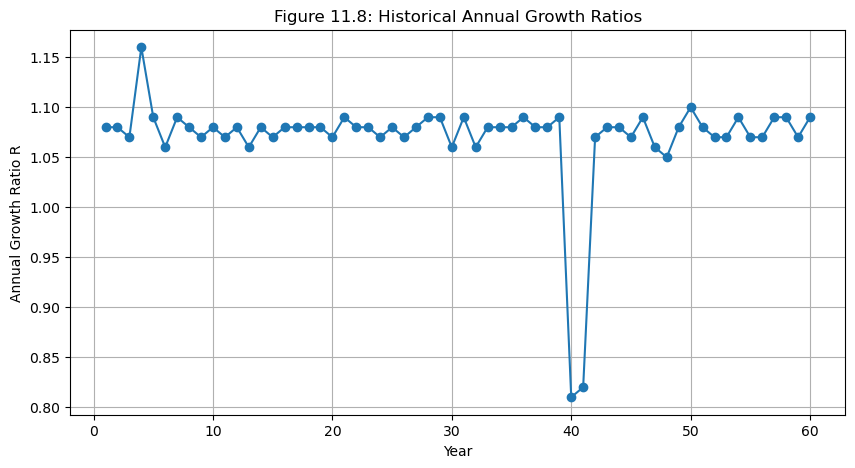

In [26]:
# Plot R over time
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(df) + 1), df['R'], marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Annual Growth Ratio R')
plt.title('Figure 11.8: Historical Annual Growth Ratios')
plt.grid(True)
plt.show()

## 3️⃣ Compute sample statistics (cells A7:B11)

**A7**: Sample Mean

**A8**: Sample Standard Deviation

**A9**: Max

**A10**: Min

**A11**: N (number of observations)

In [27]:
# Compute sample statistics
R = df['R'].values
R_mean = np.mean(R)
R_std = np.std(R, ddof=1)  # sample standard deviation
R_max = np.max(R)
R_min = np.min(R)
N = len(R)

print(f"Sample mean (A7) = {R_mean:.6f}")
print(f"Sample stdev (A8) = {R_std:.6f}")
print(f"Max (A9) = {R_max:.6f}")
print(f"Min (A10) = {R_min:.6f}")
print(f"N (A11) = {N}")

Sample mean (A7) = 1.070500
Sample stdev (A8) = 0.049997
Max (A9) = 1.160000
Min (A10) = 0.810000
N (A11) = 60


## 4️⃣ Monte Carlo simulation for finding optimal k

We simulate 10,000 trials of \(R \sim N(\hat\mu, \hat\sigma)\), and compute 
terminal wealth for an investor allocating fraction \(k\) to the risky asset and 
fraction \(1-k\) to the risk-free asset at 5%.  Starting wealth is \(W_0 = 10{,}000\).

Terminal wealth in each trial is:
\[
  W(k) = W_0 \bigl[k R + (1-k) (1.05)\bigr].
\]
We choose \(k \in [0,2]\) to maximize the expected log growth:
\[
  \max_{0 \le k \le 2} \; E\bigl[\ln\bigl(W(k)/W_0\bigr)\bigr]
  = \max_{0 \le k \le 2} \; E\bigl[\ln\bigl(k R + (1-k) 1.05\bigr)\bigr].

We use a grid search over \(k\) for simplicity.


Optimal k in [0, 2] = 2.00
Max expected log growth = 0.081249


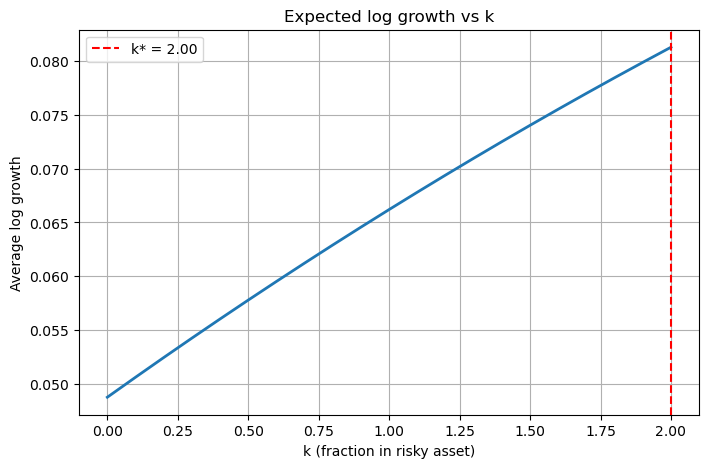

In [36]:
# Set up Monte Carlo
np.random.seed(0)
n_trials = 10000
# Draw samples of R from N(R_mean, R_std)
R_sim = np.random.normal(R_mean, R_std, size=n_trials)

# Define a function to compute average log growth for a given k
def avg_log_growth(k, R_vals):
    # risk-free growth 1.05
    portfolio_growth = k * R_vals + (1 - k) * 1.05
    # ensure no negative or zero
    return np.mean(np.log(portfolio_growth))

# Grid search over k in [0,2]
k_grid = np.linspace(0, 2, 201)  # step size 0.01
avg_logs = []
for k in k_grid:
    avg_logs.append(avg_log_growth(k, R_sim))

# Find k that maximizes avg log growth
idx_opt = np.argmax(avg_logs)
k_opt = k_grid[idx_opt]
max_avg_log = avg_logs[idx_opt]

print(f"Optimal k in [0, 2] = {k_opt:.2f}")
print(f"Max expected log growth = {max_avg_log:.6f}")

# (Optional) plot avg_log vs k
plt.figure(figsize=(8,5))
plt.plot(k_grid, avg_logs, lw=2)
plt.axvline(k_opt, color='red', linestyle='--', label=f'k* = {k_opt:.2f}')
plt.xlabel('k (fraction in risky asset)')
plt.ylabel('Average log growth')
plt.title('Expected log growth vs k')
plt.legend()
plt.grid(True)
plt.show()

## ➡️ Out-of-Sample Wealth Evolution with \(k=2\)

Now that we’ve found the “in‐sample” (historical) Kelly‐type fraction \(k\), let’s see what happens if we simply set 
\[
k = 2.0
\]
and then feed in the **future**, out-of-sample returns from `future_years.csv`.  

We will:

1. Load the new returns \(\{R_t\}\) from `future_years.csv`.
2. Start with initial wealth \(W_0 = 10000\).
3. For each period \(t\), update
   \[
     W_t = 
     \begin{cases}
       W_{t-1}, & \text{if }W_{t-1}\le 0,\\
       W_{t-1}\,\bigl[k\,R_t + (1-k)\times1.05 \bigr], & \text{if }W_{t-1}>0.
     \end{cases}
   \]
   In other words, once wealth goes non-positive, it stays “stuck” at that negative (or zero) level forever.
4. Plot \(W_t\) versus \(t\).  

This will reproduce exactly what’s in column AB of “Figs8to12” and produce Figure 11.11.
---


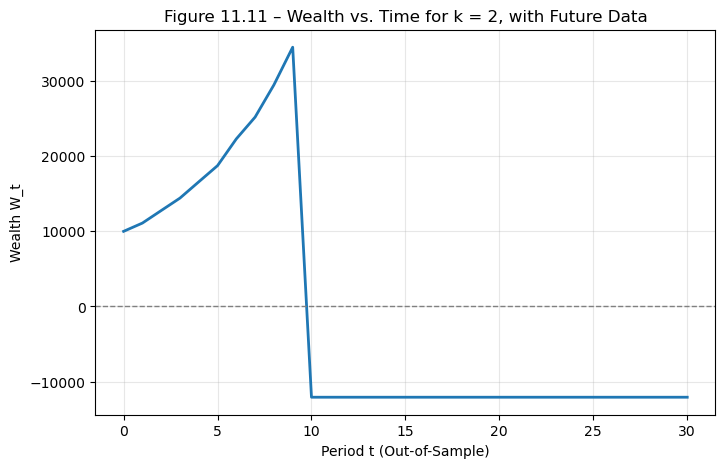

,Period,Return_R,Wealth
0,0,NaN,10000.000000
1,1,1.08,11100.000000
2,2,1.10,12765.000000
3,3,1.09,14424.450000
4,4,1.10,16588.117500
5,5,1.09,18744.572775
6,6,1.12,22306.041602
7,7,1.09,25205.827011
8,8,1.11,29490.817602
9,9,1.11,34504.256595


In [37]:
# 1️⃣ Load out-of-sample returns from future_years.csv
#    (Make sure future_years.csv is saved in the same folder as this notebook,
#     with a single column named "R" containing the annual growth ratios.)


# Read in the future returns
df_future = pd.read_csv("future_years.csv")
# Assume the column of growth ratios is named "R"
# If your CSV has a different column name, adjust below accordingly.
R_future = df_future["R"].values

# 2️⃣ Set initial wealth and fixed k = 2
W0 = 10_000
k = 2.0
risk_free = 1.05  # one‐period gross risk‐free factor

# 3️⃣ Iterate to compute wealth path, “stuck” once <= 0
wealth = [W0]
for r in R_future:
    prev = wealth[-1]
    if prev <= 0:
        # Once wealth is non-positive, it stays there
        wealth.append(prev)
    else:
        # Update: W_t = W_{t-1} * (k*R_t + (1-k)*1.05)
        next_w = prev * (k * r + (1 - k) * risk_free)
        wealth.append(next_w)

# Build a time index array 0 ... T (T = number of future data points)
time_indices = np.arange(len(wealth))

# 4️⃣ Plot the out-of-sample wealth path (recreates Figure 11.11)
plt.figure(figsize=(8, 5))
plt.plot(time_indices, wealth, lw=2)
plt.xlabel("Period t (Out-of-Sample)")
plt.ylabel("Wealth W_t")
plt.title("Figure 11.11 – Wealth vs. Time for k = 2, with Future Data")
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.grid(alpha=0.3)
plt.show()

# 5️⃣ (Optional) Display the first few values of wealth for inspection
df_out = pd.DataFrame({
    "Period": time_indices,
    "Return_R": np.concatenate(([np.nan], R_future)),  # align: R_future[0] applies to period 1
    "Wealth": wealth
})
df_out.head(12)


In [38]:

df_hist = df
R_hist = df_hist["R"].values

# 2️⃣ Compute sample mean and stdev (if not already done)
sample_mean = np.mean(R_hist)
sample_stdev = np.std(R_hist, ddof=1)

# 3️⃣ Define the set of percentiles used in E7:E15 (i.e. 1%, 5%, 10%, 25%, 50%, 75%, 90%, 95%, 99%)
percentiles = np.array([0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99])

# 4️⃣ Compute the empirical quantiles of the R–data at exactly those percentiles
#    Note: np.percentile expects percentile*100
empirical_quantiles = np.percentile(R_hist, percentiles * 100)

# 5️⃣ Compute the Normal‐model quantiles with N(mean=sample_mean, sd=sample_stdev)
normal_quantiles = stats.norm.ppf(percentiles, loc=sample_mean, scale=sample_stdev)

# 6️⃣ Build a DataFrame to mimic E6:G15 (E6 and F6 are headers)
df_pct = pd.DataFrame({
    "%Rank In Data": percentiles,
    "Empirical R": empirical_quantiles,
    "Normal Model R": normal_quantiles
})

# 7️⃣ Display exactly the rows and columns corresponding to E6:G15
#    (Row count = 9 percentiles; column order matches E, F, G)
df_pct.index = np.arange(7, 7 + len(percentiles))  # so index matches Excel row numbers if you like
df_pct.columns = ["%Rank In Data", "Empirical R", "NORMAL Model"]

df_pct


,%Rank In Data,Empirical R,NORMAL Model
7,0.01,0.8159,0.954189
8,0.05,1.0595,0.988262
9,0.10,1.0600,1.006426
10,0.25,1.0700,1.036777
11,0.50,1.0800,1.070500
12,0.75,1.0825,1.104223
13,0.90,1.0900,1.134574
14,0.95,1.0900,1.152738
15,0.99,1.1246,1.186811


Fitted VG parameters (method‐of‐moments):
  mu    = 1.070500
  sigma = 0.049997
  nu    = 6.916424   (Excess kurtosis = 20.749271)

Optimal k under fitted VG (grid search): 2.000
Max expected log‐growth ≈ 0.083693



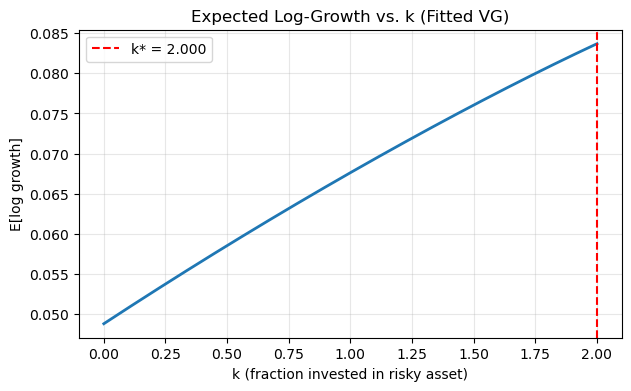

In [39]:

from scipy.stats import kurtosis, gamma


# 1️⃣ Assume `df` already contains the 60 historical R values in column "R":
R_hist = df["R"].values  # from years 1–60

# 2️⃣ Compute sample moments (mean, variance, kurtosis)
mu_hat = np.mean(R_hist)
var_hat = np.var(R_hist, ddof=1)
kurt_hat = kurtosis(R_hist, fisher=False)  # Pearson kurtosis
excess_kurt = kurt_hat - 3

# 3️⃣ Method‐of‐Moments fit of a symmetric Variance‐Gamma:
#    For a symmetric VG, Excess Kurtosis = 3*nu, Var = sigma^2, and mean = mu.
nu = excess_kurt / 3
sigma = np.sqrt(var_hat)

print(f"Fitted VG parameters (method‐of‐moments):")
print(f"  mu    = {mu_hat:.6f}")
print(f"  sigma = {sigma:.6f}")
print(f"  nu    = {nu:.6f}   (Excess kurtosis = {excess_kurt:.6f})\n")

# 4️⃣ Draw 10,000 samples R_vg from this fitted VG distribution:
Nsim = 10_000
a = 1.0 / nu        # gamma shape
scale = nu          # gamma scale
G_draws = gamma.rvs(a=a, scale=scale, size=Nsim, random_state=12345)
Z = np.random.default_rng(54321).standard_normal(Nsim)
R_vg = mu_hat + sigma * np.sqrt(G_draws) * Z

# 5️⃣ Define function to compute expected log‐growth given k
risk_free = 1.05
def expected_log_growth_vg(k, R_draws):
    port_returns = k * R_draws + (1.0 - k) * risk_free
    # Avoid log(≤0) by replacing any nonpositive with a tiny positive number
    port_returns = np.where(port_returns > 0, port_returns, 1e-12)
    return np.mean(np.log(port_returns))

# 6️⃣ Grid‐search over k ∈ [0, 2]
k_grid = np.linspace(0, 2, 1001)
elog_vals = np.array([expected_log_growth_vg(k, R_vg) for k in k_grid])

# 7️⃣ Find optimal k
idx_opt = np.nanargmax(elog_vals)
k_opt_vg = k_grid[idx_opt]
max_elog = elog_vals[idx_opt]

print(f"Optimal k under fitted VG (grid search): {k_opt_vg:.3f}")
print(f"Max expected log‐growth ≈ {max_elog:.6f}\n")

# 8️⃣ (Optional) Plot E[log‐growth] vs. k
plt.figure(figsize=(7, 4))
plt.plot(k_grid, elog_vals, lw=2)
plt.axvline(k_opt_vg, color="red", linestyle="--", label=f"k* = {k_opt_vg:.3f}")
plt.xlabel("k (fraction invested in risky asset)")
plt.ylabel("E[log growth]")
plt.title("Expected Log‐Growth vs. k (Fitted VG)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


Fitted Student’s t parameters:
  nu (df)  = 1.3761
  loc (μ)  = 1.079131
  scale (σ)= 0.007010

Optimal k under fitted Student’s t (grid search): 1.574
Max expected log‐growth ≈ 0.071053



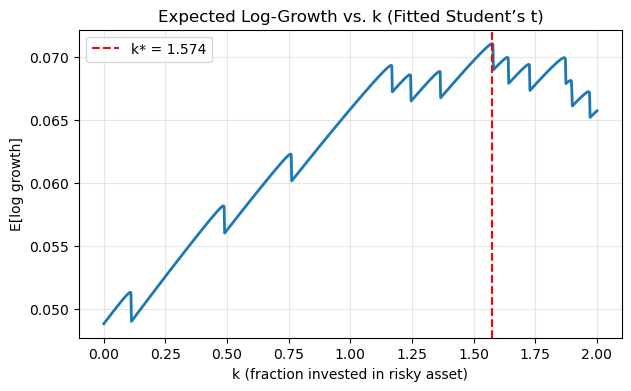

In [40]:

from scipy.stats import t

# 1️⃣ Assume `R_hist = df["R"].values` already exists:
#    (60 historical growth ratios from years 1–60)

# 2️⃣ Fit a Student’s t distribution via MLE:
#    This returns (df_fit, loc_fit, scale_fit)
df_fit, loc_fit, scale_fit = t.fit(R_hist)

print(f"Fitted Student’s t parameters:")
print(f"  nu (df)  = {df_fit:.4f}")
print(f"  loc (μ)  = {loc_fit:.6f}")
print(f"  scale (σ)= {scale_fit:.6f}\n")

# 3️⃣ Draw 10,000 samples from this fitted t:
Nsim = 10_000
rng = np.random.default_rng(24680)
R_tdraws = t.rvs(df_fit, loc=loc_fit, scale=scale_fit, size=Nsim, random_state=rng)

# 4️⃣ Define expected log‐growth function (same as before):
risk_free = 1.05
def expected_log_growth_t(k, R_draws):
    port_returns = k * R_draws + (1.0 - k) * risk_free
    port_returns = np.where(port_returns > 0, port_returns, 1e-12)
    return np.mean(np.log(port_returns))

# 5️⃣ Grid‐search over k ∈ [0, 2]:
k_grid = np.linspace(0, 2, 1001)
elog_t_vals = np.array([expected_log_growth_t(k, R_tdraws) for k in k_grid])

# 6️⃣ Find the optimal k:
idx_opt_t = np.nanargmax(elog_t_vals)
k_opt_t = k_grid[idx_opt_t]
max_elog_t = elog_t_vals[idx_opt_t]

print(f"Optimal k under fitted Student’s t (grid search): {k_opt_t:.3f}")
print(f"Max expected log‐growth ≈ {max_elog_t:.6f}\n")

# 7️⃣ (Optional) Plot E[log‐growth] vs. k for the t model:
plt.figure(figsize=(7, 4))
plt.plot(k_grid, elog_t_vals, lw=2)
plt.axvline(k_opt_t, color="red", linestyle="--", label=f"k* = {k_opt_t:.3f}")
plt.xlabel("k (fraction invested in risky asset)")
plt.ylabel("E[log growth]")
plt.title("Expected Log‐Growth vs. k (Fitted Student’s t)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


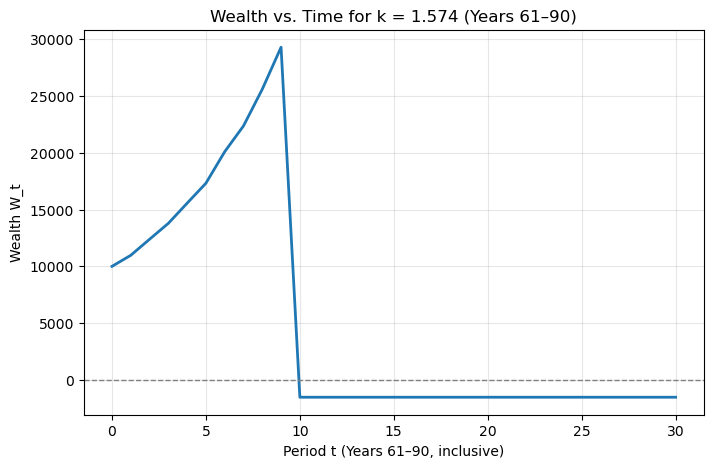

,Period,Return_R,Wealth
0,0,NaN,10000.000000
1,1,1.08,10972.200000
2,2,1.10,12384.322140
3,3,1.09,13783.255169
4,4,1.10,15557.160109
5,5,1.09,17314.496915
6,6,1.12,20087.933031
7,7,1.09,22357.065946
8,8,1.11,25586.320551
9,9,1.11,29282.008692


In [41]:
# ─── Wealth Evolution for Years 61–90 Using k_opt_t ───

import numpy as np
import matplotlib.pyplot as plt

# 1️⃣ Assume R_future already contains returns for years 61–90:
#    (loaded previously via df_future = pd.read_csv("future_years.csv"))
#    So R_future is a NumPy array of length 30.

# 2️⃣ Use the previously computed optimal fraction from the Student’s t fit:
#    k_opt_t  (make sure this variable exists)

# 3️⃣ Set initial wealth and risk-free factor:
W0 = 10_000
k = k_opt_t
risk_free = 1.05  # one-period gross risk-free return

# 4️⃣ Iterate to compute the wealth path, “stuck” once <= 0:
wealth_t = [W0]
for r in R_future:
    prev = wealth_t[-1]
    if prev <= 0:
        # Wealth remains at the same non-positive level
        wealth_t.append(prev)
    else:
        # Update: W_t = W_{t-1} * (k*R + (1-k)*1.05)
        next_w = prev * (k * r + (1 - k) * risk_free)
        wealth_t.append(next_w)

# 5️⃣ Build a time index array 0 ... 30 (for initial + 30 future years)
time_idx = np.arange(len(wealth_t))

# 6️⃣ Plot the wealth path for years 61–90:
plt.figure(figsize=(8, 5))
plt.plot(time_idx, wealth_t, lw=2)
plt.xlabel("Period t (Years 61–90, inclusive)")
plt.ylabel("Wealth W_t")
plt.title(f"Wealth vs. Time for k = {k_opt_t:.3f} (Years 61–90)")
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.grid(alpha=0.3)
plt.show()

# 7️⃣ (Optional) Tabulate the first few wealth values:
import pandas as pd
df_wealth_t = pd.DataFrame({
    "Period": time_idx,
    "Return_R": np.concatenate(([np.nan], R_future)),
    "Wealth": wealth_t
})
df_wealth_t.head(12)


Normal parameters:    μ = 1.070500,  σ = 0.049997
Laplace parameters:   loc = 0.985000,  scale = 0.175000
Mixture weights:     p_norm = 0.9667,  p_lap = 0.0333

Optimal k (Normal+Laplace tails) = 1.370
Max expected log-growth ≈ 0.067167



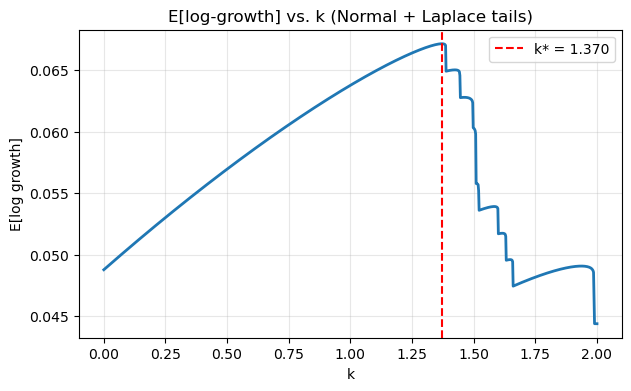

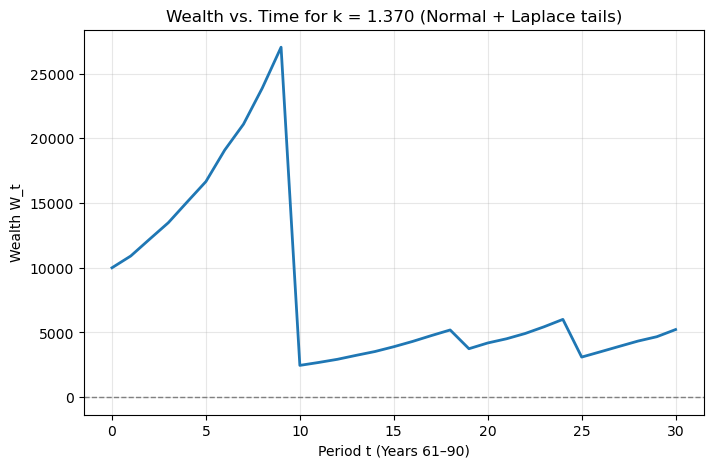

,Period,Return_R,Wealth
0,0,NaN,10000.000000
1,1,1.08,10911.000000
2,2,1.10,12203.953500
3,3,1.09,13482.927827
4,4,1.10,15080.654774
5,5,1.09,16661.107395
6,6,1.12,19091.962963
7,7,1.09,21092.800682
8,8,1.11,23881.268932
9,9,1.11,27038.372685


In [42]:
# ─── Fit “Normal with Laplace Tails” Using (max+min)/2 and (max-min)/2, Then Evaluate ───

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import laplace, norm

# 1️⃣ Assume R_hist = df["R"].values already exists (years 1–60)

# 2️⃣ Compute Normal parameters (μ, σ)
mu_hat = np.mean(R_hist)
sigma_hat = np.std(R_hist, ddof=1)

# 3️⃣ Compute Laplace parameters per book: 
#    loc = (max + min) / 2,  scale = (max - min) / 2
max_r, min_r = R_hist.max(), R_hist.min()
loc_lap = 0.5 * (max_r + min_r)
scale_lap = 0.5 * (max_r - min_r)

# 4️⃣ Mixture weights: p_lap = 2/60, p_norm = 58/60
N = len(R_hist)
p_lap = 2.0 / N
p_norm = 1.0 - p_lap

print(f"Normal parameters:    μ = {mu_hat:.6f},  σ = {sigma_hat:.6f}")
print(f"Laplace parameters:   loc = {loc_lap:.6f},  scale = {scale_lap:.6f}")
print(f"Mixture weights:     p_norm = {p_norm:.4f},  p_lap = {p_lap:.4f}\n")

# 5️⃣ Simulate 10,000 draws from the Normal+Laplace mixture:
Nsim = 10_000
rng = np.random.default_rng(13579)

us = rng.random(Nsim)
R_mix = np.empty(Nsim)

lap_idx = (us < p_lap)
norm_idx = ~lap_idx

R_mix[lap_idx] = laplace.rvs(loc=loc_lap, scale=scale_lap,
                              size=lap_idx.sum(), random_state=rng)
R_mix[norm_idx] = norm.rvs(loc=mu_hat, scale=sigma_hat,
                            size=norm_idx.sum(), random_state=rng)

# 6️⃣ Define E[log-growth] under mixture draws:
risk_free = 1.05
def expected_log_growth_mix(k, R_draws):
    port_ret = k * R_draws + (1.0 - k) * risk_free
    port_ret = np.where(port_ret > 0, port_ret, 1e-12)
    return np.mean(np.log(port_ret))

# 7️⃣ Grid-search k ∈ [0,2]:
k_grid = np.linspace(0, 2, 1001)
elog_mix_vals = np.array([expected_log_growth_mix(k, R_mix) for k in k_grid])

idx_opt_mix = np.nanargmax(elog_mix_vals)
k_opt_mix = k_grid[idx_opt_mix]
max_elog_mix = elog_mix_vals[idx_opt_mix]

print(f"Optimal k (Normal+Laplace tails) = {k_opt_mix:.3f}")
print(f"Max expected log-growth ≈ {max_elog_mix:.6f}\n")

# 8️⃣ Plot E[log-growth] vs. k:
plt.figure(figsize=(7, 4))
plt.plot(k_grid, elog_mix_vals, lw=2)
plt.axvline(k_opt_mix, color="red", linestyle="--", label=f"k* = {k_opt_mix:.3f}")
plt.xlabel("k")
plt.ylabel("E[log growth]")
plt.title("E[log-growth] vs. k (Normal + Laplace tails)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# 9️⃣ Evaluate on years 61–90 (R_future must exist):
W0 = 10_000
k = k_opt_mix
wealth_mix = [W0]

for r in R_future:
    prev = wealth_mix[-1]
    if prev <= 0:
        wealth_mix.append(prev)
    else:
        next_w = prev * (k * r + (1 - k) * risk_free)
        wealth_mix.append(next_w)

time_idx = np.arange(len(wealth_mix))

# 10️⃣ Plot out-of-sample wealth:
plt.figure(figsize=(8, 5))
plt.plot(time_idx, wealth_mix, lw=2)
plt.xlabel("Period t (Years 61–90)")
plt.ylabel("Wealth W_t")
plt.title(f"Wealth vs. Time for k = {k_opt_mix:.3f} (Normal + Laplace tails)")
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.grid(alpha=0.3)
plt.show()

# 11️⃣ (Optional) Display first few values:
df_wealth_mix = pd.DataFrame({
    "Period": time_idx,
    "Return_R": np.concatenate(([np.nan], R_future)),
    "Wealth": wealth_mix
})
df_wealth_mix.head(12)


In [43]:
# 1️⃣ Define the “true” return process parameters (pages 505–506):
#    With probability 0.95: R ~ Normal(mean=1.08,  sd=0.01)
#    With probability 0.05: R ~ Normal(mean=0.89,  sd=0.36)
p1, mu1, sd1 = 0.95, 1.08, 0.01
p2, mu2, sd2 = 0.05, 0.89, 0.36

# 2️⃣ Simulation setup:
W0 = 10_000                 # initial wealth
kN = 2.0                    # k under the Normal‐only model
kH = 1.37                   # k under the Normal+Laplace‐tails model (from prior step)
risk_free = 1.05            # one‐period gross risk‐free return
T = 30                      # number of years to simulate (years 61–90)
M = 10_000                  # number of Monte Carlo trials

rng = np.random.default_rng(20250602)  # for reproducibility

# 3️⃣ Function to simulate one path of length T under true process:
def simulate_path_returns(T):
    """
    Simulate T returns from the mixture:
      with prob p1: N(mu1, sd1),
      with prob p2: N(mu2, sd2).
    Returns an array of length T.
    """
    # Draw T uniforms to decide regime
    u = rng.random(T)
    # Initialize array
    R = np.empty(T)
    # Indices for regime 1 and regime 2
    idx1 = (u < p1)
    idx2 = ~idx1
    
    # Draw from the appropriate normal distributions
    R[idx1] = rng.normal(loc=mu1, scale=sd1, size=idx1.sum())
    R[idx2] = rng.normal(loc=mu2, scale=sd2, size=idx2.sum())
    return R

# 4️⃣ Simulate M independent paths of length T, track bankruptcy for each k:
#    Bankruptcy = wealth ever ≤ 0 during the T‐year horizon
bankrupt_N = np.zeros(M, dtype=bool)
bankrupt_H = np.zeros(M, dtype=bool)

for i in range(M):
    R_path = simulate_path_returns(T)
    
    # Simulate wealth for kN = 2.0
    W = W0
    has_gone_bankrupt = False
    for r in R_path:
        if W <= 0:
            has_gone_bankrupt = True
            break
        W = W * (kN * r + (1 - kN) * risk_free)
    bankrupt_N[i] = has_gone_bankrupt or (W <= 0)
    
    # Simulate wealth for kH = 1.37
    W = W0
    has_gone_bankrupt = False
    for r in R_path:
        if W <= 0:
            has_gone_bankrupt = True
            break
        W = W * (kH * r + (1 - kH) * risk_free)
    bankrupt_H[i] = has_gone_bankrupt or (W <= 0)

# 5️⃣ Compute estimated bankruptcy probabilities:
prob_bankrupt_N = bankrupt_N.mean()
prob_bankrupt_H = bankrupt_H.mean()

print(f"Estimated Probability of Bankruptcy (k = 2.0, Normal model):    {prob_bankrupt_N:.3f}")
print(f"Estimated Probability of Bankruptcy (k = 1.37, Hybrid model):    {prob_bankrupt_H:.3f}")


Estimated Probability of Bankruptcy (k = 2.0, Normal model):    0.206
Estimated Probability of Bankruptcy (k = 1.37, Hybrid model):    0.066
